In [ ]:
# mlp_smoa_forest_cover.py
"""
MLP + SMOA optimisation sur le dataset Forest Cover Type
Colonne cible : Cover_Type (7 classes)
Split : 80% train / 20% test
Sauvegarde dans results_smoa/
"""

import os, json, joblib, inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = [12, 8]

RND = 42
DATA_PATH = "data/covtype.csv"
SAVE_DIR = "results_smoa"
os.makedirs(SAVE_DIR, exist_ok=True)
SAVE_PREFIX = "best_model_smoa"
SAVE_JSON = os.path.join(SAVE_DIR, "best_hyperparameters.json")
SAVE_REPORT = os.path.join(SAVE_DIR, "classification_report_smoa.txt")
SAVE_GRAPH = os.path.join(SAVE_DIR, "graphs_summary_smoa.png")

# ---------------------------
#  SMOA
# ---------------------------
class SMOA:
    def __init__(self, obj_fn, dim, pop_size=8, lb=-3.0, ub=3.0, max_iter=15,
                 mag_strength=0.8, scent_radius=0.5, decay_rate=0.05,
                 sinus_amp=0.1, sinus_freq=0.05, diversity_threshold=1e-4,
                 early_stop=6, seed=None):
        self.obj = obj_fn
        self.dim = dim
        self.pop_size = pop_size
        self.lb = np.ones(dim) * lb if np.isscalar(lb) else np.array(lb)
        self.ub = np.ones(dim) * ub if np.isscalar(ub) else np.array(ub)
        self.max_iter = max_iter
        self.rng = np.random.default_rng(seed)
        self.mag_strength0 = mag_strength
        self.scent_radius0 = scent_radius
        self.decay_rate = decay_rate
        self.sinus_amp = sinus_amp
        self.sinus_freq = sinus_freq
        self.diversity_threshold = diversity_threshold
        self.early_stop = early_stop

    def clamp(self, pop):
        return np.clip(pop, self.lb, self.ub)

    def population_diversity(self, pop):
        return np.mean(np.std(pop, axis=0))

    def adapt_parameters(self, t):
        exp_term = np.exp(-self.decay_rate * t)
        mag = self.mag_strength0 * exp_term + self.sinus_amp * np.sin(2*np.pi*self.sinus_freq*t)
        scent = self.scent_radius0 * exp_term * (0.7 + 0.3*np.sin(2*np.pi*self.sinus_freq*t))
        return max(1e-6, mag), max(1e-6, scent)

    def magnet_move(self, x, best, mag_strength):
        direction = best - x
        dist = np.linalg.norm(direction)
        if dist > 1e-12:
            unit = direction / dist
        else:
            unit = self.rng.normal(size=self.dim)
            unit /= np.linalg.norm(unit)
        rand = self.rng.normal(size=self.dim)
        step = mag_strength * (unit * (0.5 + self.rng.random()) + 0.1 * rand)
        return x + step

    def scent_local_search(self, x, scent_radius, n_samples=3):
        best_x = x.copy()
        best_val, _ = self.obj(best_x)
        for _ in range(n_samples):
            direction = self.rng.normal(size=self.dim)
            nrm = np.linalg.norm(direction)
            if nrm > 0:
                direction = direction / nrm
            r = (self.rng.random() ** (1/self.dim))
            candidate = x + direction * r * scent_radius * (self.ub - self.lb)
            candidate = self.clamp(candidate)
            val, _ = self.obj(candidate)
            if val < best_val:
                best_x = candidate.copy()
                best_val = val
        return best_x, best_val

    def run(self, verbose=True):
        if verbose: print("Démarrage SMOA (Forest Cover Type)...")
        pop = self.rng.uniform(self.lb, self.ub, size=(self.pop_size, self.dim))
        fitness = np.array([self.obj(x)[0] for x in pop])
        best_idx = np.argmin(fitness)
        gbest = pop[best_idx].copy()
        gbest_val, gbest_metrics = self.obj(gbest)
        no_improve = 0
        history = {"best": [gbest_val], "mean": [np.mean(fitness)], "best_params": []}

        for t in range(self.max_iter):
            if verbose:
                print(f"SMOA itération {t+1}/{self.max_iter} | meilleure perte actuelle: {gbest_val:.5f}")
            mag_strength, scent_radius = self.adapt_parameters(t)
            div = self.population_diversity(pop)
            if div < self.diversity_threshold:
                mag_strength *= 0.5
                scent_radius *= 1.5

            new_pop = pop.copy()
            new_fit = fitness.copy()

            for i in range(self.pop_size):
                x = pop[i]
                moved = self.magnet_move(x, gbest, mag_strength)
                local_x, local_f = self.scent_local_search(moved, scent_radius)
                new_pop[i] = local_x
                new_fit[i] = local_f
                if local_f < gbest_val:
                    gbest = local_x.copy()
                    gbest_val = local_f
                    gbest_metrics = self.obj(gbest)[1]
                    no_improve = 0

            pop = new_pop
            fitness = new_fit

            history["best"].append(gbest_val)
            history["mean"].append(np.mean(fitness))
            history["best_params"].append(gbest_metrics.get("params", {}))

            if verbose:
                print(f" → meilleure perte: {gbest_val:.6f}")
            if no_improve >= self.early_stop:
                if verbose: print("Arrêt anticipé (pas d'amélioration)")
                break

        if verbose: print("SMOA terminé.")
        return gbest, gbest_val, gbest_metrics, history

# ---------------------------
#  Chargement & prétraitement
# ---------------------------
def load_dataset(path=DATA_PATH):
    df = pd.read_csv(path)
    print(f"Dataset chargé : {df.shape[0]} lignes × {df.shape[1]} colonnes")
    return df

def preprocess_forest_cover(df):
    X = df.drop(columns=["Cover_Type"])
    y = df["Cover_Type"].values - 1  # 0-6 pour sklearn
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)  # <-- évite warning
    return X_scaled, y, scaler

# ---------------------------
#  Objective
# ---------------------------
def make_objective(X_train, X_val, y_train, y_val, n_epochs_eval=15):
    activations = ["relu", "tanh", "logistic"]
    solvers = ["adam", "sgd"]

    def obj_fn(vec):
        vec = np.asarray(vec)
        # Limitation des tailles pour éviter overflow
        h1 = max(16, min(128, int(round(abs(vec[0])*128))+16))
        h2 = max(8,  min(64, int(round(abs(vec[1])*64))+8))
        hidden_layers = (h1, h2)
        act_idx = int(abs(vec[2])*len(activations)) % len(activations)
        activation = activations[act_idx]
        solver_idx = int(abs(vec[3])*len(solvers)) % len(solvers)
        solver = solvers[solver_idx]
        alpha = 10 ** np.clip(vec[4], -6, 0)
        max_iter = int(50 + np.clip(vec[5],0,1)*350)
        lr_init = 10 ** np.clip(vec[6], -5, -1)
        beta_1 = np.clip(vec[7], 0.8, 0.999)
        beta_2 = np.clip(vec[8], 0.9, 0.9999)
        tol = 10 ** np.clip(vec[9], -7, -3)

        params = {
            "hidden_layer_sizes": hidden_layers,
            "activation": activation,
            "solver": solver,
            "alpha": alpha,
            "max_iter": max_iter,
            "learning_rate_init": lr_init,
            "beta_1": beta_1,
            "beta_2": beta_2,
            "tol": tol,
            "random_state": RND,
            "verbose": False
        }

        sig = inspect.signature(MLPClassifier.__init__)
        accepted = {k for k in sig.parameters.keys() if k != "self"}
        filtered = {k:v for k,v in params.items() if k in accepted}

        try:
            model = MLPClassifier(**filtered)
            classes = np.unique(y_train)
            for _ in range(n_epochs_eval):
                idx = np.random.permutation(len(X_train))
                model.partial_fit(X_train.iloc[idx], y_train[idx], classes=classes)
            val_acc = model.score(X_val, y_val)
            loss = 1.0 - val_acc
            metrics = {"params": params, "val_acc": val_acc}
        except:
            loss = 1.0
            metrics = {"params": params}

        return loss, metrics

    return obj_fn

# ---------------------------
#  Train final model
# ---------------------------
def train_final_model(params, X_train, X_test, y_train, y_test, n_epochs=40):
    sig = inspect.signature(MLPClassifier.__init__)
    accepted = {k for k in sig.parameters.keys() if k != "self"}
    filtered = {k:v for k,v in params.items() if k in accepted}

    model = MLPClassifier(**filtered)
    classes = np.unique(y_train)
    train_accs, val_accs, losses = [], [], []

    for epoch in range(1, n_epochs+1):
        idx = np.random.permutation(len(X_train))
        model.partial_fit(X_train.iloc[idx], y_train[idx], classes=classes)

        train_acc = accuracy_score(y_train, model.predict(X_train))
        val_acc = accuracy_score(y_test, model.predict(X_test))
        loss = getattr(model, "loss_", np.nan)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        losses.append(loss)

        print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f}")

    return model, {"train_acc": train_accs, "val_acc": val_accs, "loss": losses}

# ---------------------------
#  Main
# ---------------------------
def main():
    df = load_dataset()
    X, y, scaler = preprocess_forest_cover(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RND, stratify=y)
    print(f"Train: {X_train.shape} | Test: {X_test.shape}")

    # SMOA optimisation
    obj = make_objective(X_train, X_test, y_train, y_test, n_epochs_eval=15)
    smoa = SMOA(obj, dim=10, pop_size=5, max_iter=3, seed=RND)
    best_vec, best_loss, best_metrics, history = smoa.run(verbose=True)

    print("\nMeilleurs hyperparamètres trouvés :", best_metrics["params"])

    # Entraînement final
    final_model, hist = train_final_model(best_metrics["params"], X_train, X_test, y_train, y_test, n_epochs=20)

    # Évaluation
    y_pred = final_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy finale : {acc:.4f}")

    # Sauvegarde
    joblib.dump(final_model, os.path.join(SAVE_DIR, f"{SAVE_PREFIX}.pkl"))
    joblib.dump(scaler, os.path.join(SAVE_DIR, "scaler_smoa.pkl"))
    with open(SAVE_JSON, "w") as f:
        json.dump(best_metrics["params"], f, indent=4)
    with open(SAVE_REPORT, "w") as f:
        f.write(classification_report(y_test, y_pred))

    # Graphique
    plt.figure(figsize=(10,6))
    epochs = range(1, len(hist["loss"])+1)
    plt.plot(epochs, hist["loss"], label="Loss")
    plt.plot(epochs, hist["train_acc"], label="Train Acc")
    plt.plot(epochs, hist["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Évolution pendant l'entraînement final")
    plt.xlabel("Epoch")
    plt.tight_layout()
    plt.savefig(SAVE_GRAPH, dpi=300)
    plt.show()

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matrice de confusion - MLP + SMOA")
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix_smoa.png"), dpi=300)
    plt.show()

    print(f"\nTout sauvegardé dans : {SAVE_DIR}/")

if __name__ == "__main__":
    main()


Dataset chargé : 581012 lignes × 55 colonnes
Train: (464809, 54) | Test: (116203, 54)
Démarrage SMOA (Forest Cover Type)...


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Distribution (nombre d'exemples par classe) :
Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


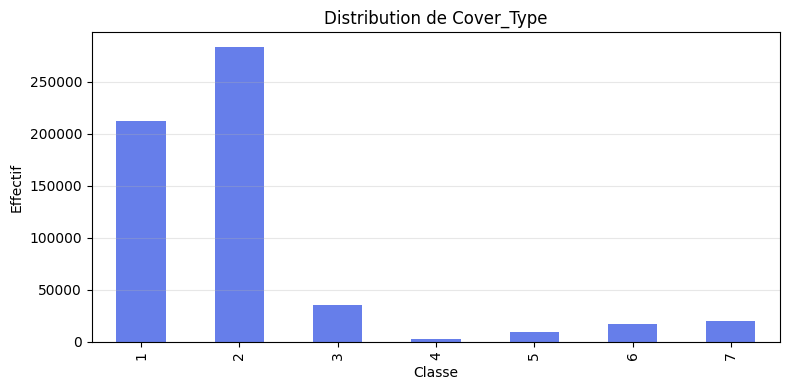

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Chemin du dataset
path = "data/covtype.csv"

df = pd.read_csv(path)
counts = df["Cover_Type"].value_counts().sort_index()

print("Distribution (nombre d'exemples par classe) :")
print(counts)

# Barplot
plt.figure(figsize=(8,4))
counts.plot(kind="bar", color="#667eea")
plt.title("Distribution de Cover_Type")
plt.xlabel("Classe")
plt.ylabel("Effectif")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()